In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [72]:
import util
import importlib
importlib.reload(util)
from collections import OrderedDict
from pylab import rcParams
style.use('ggplot')
rcParams['legend.frameon'] = True
rcParams['legend.framealpha'] = 0.8
rcParams['figure.titlesize'] = 'large'
rcParams['font.size'] = 8
rcParams['legend.fontsize'] = 8
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8

Kudos to Marcel Raas. I'm gonna do this as quick as possible. If you want to fully understand this you should enroll in an academic course of at least a semester ;) but this will suffice for some intuition and ability to apply it.

# Why this lecture?

Let's have a look at the following stock market graph:

<center><img src=images/rw-2-awr-random.png width=50%></center>

The graph looks quite random, but there seems to be a repeating pattern. How could we determine the periodicity?

By eye, we would find the peaks and calculate the distances between them.
However, the random noise will wreck any attempt of finding distances by peaks in an automated way.

We could smooth the signal (Gaussian smoothing with parameter $\sigma$) to get rid of most of the noise, followed by making a distribution of the distances of the $k$ nearest neighbours. The period will then hopefully be visible as a peak in this distribution.

This is quite a complex algorithm, and requires a lot of tuning:
* What value should we pick for $\sigma$?
* What value should we pick for $k$?
* How do we find the peak in the distribution of peak-to-peak distances? 

# Why use the Fourier transform?

The Fourier transformation will tell you how to break up a signal into signals that are periodic. You will get the all frequencies/periods in your signal and it will tell you how much it contributes to the total as well!

Clearly it has an application in **sound data**, where the periodicity corresponds to the pitch of a sound, e.g. notes in music and intonation in speech.

<center><img src=images/music.png width=40%></center>

We started the lecture with a timeseries application (e.g. stock markets, power consumption/production). Fourier will help you to discover:
* Seasonal patterns
* Weekly patterns
* And other patterns that you did not think of yet :-)

The signal can be extended to 2D data. So also image data can be decomposed into frequencies. 

This is for instance used in image compression, where the data for some frequencies that are not really important for the picture's perception is thrown away.

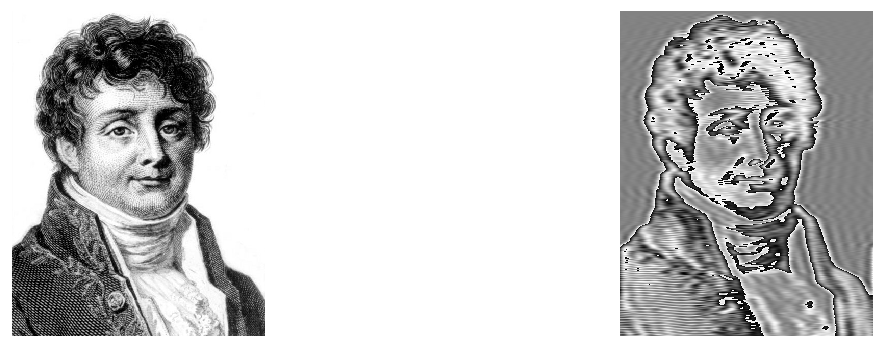

In [66]:
# Example: filtering in frequency domain.
import numpy.fft as fft
im = util.imread('images/jjfourier.jpg', edit_dir=True)
trans = fft.rfft2(im)
window_size = 20
trans[:, window_size:trans.shape[1]-window_size] = 0
util.image_subplots([im, fft.irfft2(-trans)])

Good to remember: low frequencies correspond to large-scale phenomena. High frequencies corresponds to local phenomena.

Is there a mathematical way to seperate out these periodic patterns?

**Yes**: namely the Fourier transform, named after the French mathematician Jean-Baptiste Joseph Fourier.

# Module objectives

In this module we will introduce the Fourier transform, an extremely powerful function approximation tool for signal processing. It will not be completely nailed down, but we'll get familiar with some of the concepts.

We will begin with a trigonometry refresher, and show how sinusoids can be composed to form a square wave. We'll then introduce the concept of the Fourier series and show how it can approximate the square wave.

We'll then present the Fourier transform as a generalisation of the Fourier series, and show how its discrete formulation (DFT) can be use to solve two classes of time series problems: extrapolation and outlier detection.

# Fourier Analysis

In the very essence, Fourier analyses is a branch of mathematics that studies how functions can be approximated by means of simpler trigonometric functions.

### Trigonometry 101

Take a few minutes to refresh your knowledge of trigonometry, and try to answer the following question using Python if necessary: what is the relationship between the $sin$ and $cos$ functions, and the right triangle?



![triangle](images/right_triangle.png)

$sin$ = ?

$cos$ = ?

$tan$ = ?

Remember: a very useful way of describing angles is in terms of radians. There are $2 \pi$ or 6.28 radians in 360 degrees.

#### Sinusoidal waves

Lets introduce (or refresh) the main terminology that we will encounter in this module.

![title](images/wave.jpg)

$Sinusoidal Wave = Amplitude * \sin(Frequency * Time + Phase)$

$f(t) = A \cdot \sin(2\pi\cdot t + \phi)$

#### Phasors

In [73]:
from IPython.display import HTML
HTML('<iframe src=https://betterexplained.com/examples/fourier/?cycles=0,1,1 width=600 height=280></iframe>')

Credits to http://nbviewer.jupyter.org/github/mantaraya36/201A-ipython/blob/master/Sinusoids%20and%20Phasors.ipynb?create=1 (Go over this)

A complex number representing a time-invariant sinusoidal function with constant phase, amplitude and frequency.

An angle (for a constant rotating line of length A) changes at a constant speed.

Adding two sinusoids of the same frequency will always result in the same frequency, no matter the phase.

The resulting amplitude of the sum depends on the original sinusoids' amplitude and their phase relationships

You can easily calculate this with phasors. Adding sinusoids is the same as adding the rotating phasor vectors.

#### Adding sinusoids

By defining appropriate relationships between amplitude and frequency we can create funny waves

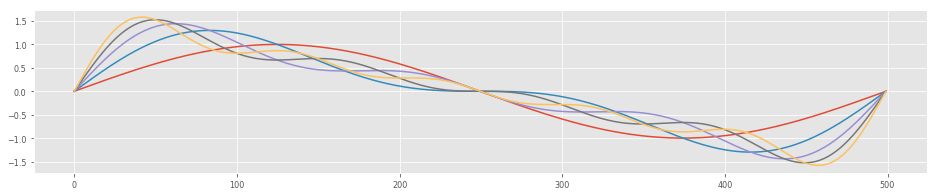

In [74]:
def add_harmonics(num, amp_harm_rel, numpoints=500):
    x = linspace(0, 2*pi, numpoints)
    out = zeros_like(x)
    harmonics = arange(num) + 1
    amps = amp_harm_rel(harmonics)
    for harm, amp in zip(harmonics, amps):
        out += amp * sin(x * harm)
    return out

amp_harm_rel = lambda x: 1.0/x
for i in range(0,5):
    plot(add_harmonics(i + 1, amp_harm_rel))

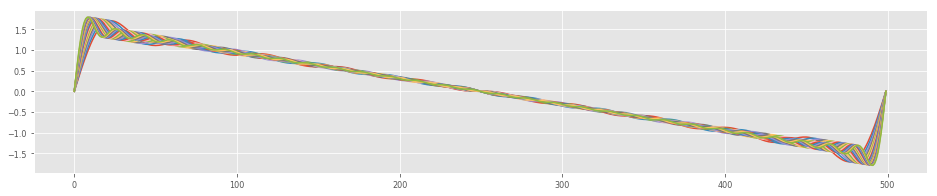

In [75]:
for i in range(20):
    plot(add_harmonics(i + 10, amp_harm_rel))

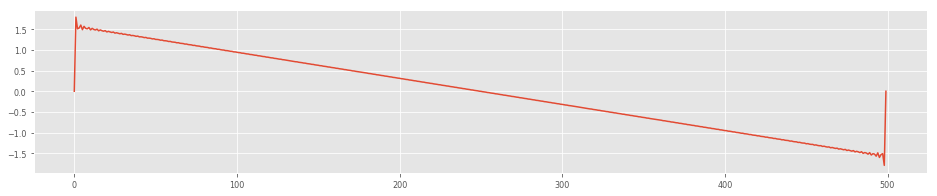

In [76]:
plot(add_harmonics(300, amp_harm_rel));

That's almost a straight line!

We can construct square waves by adding only odd harmonics

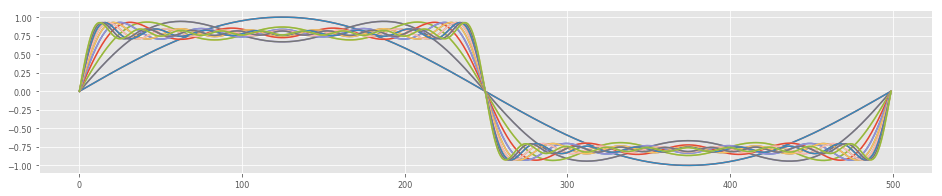

In [77]:
amp_harm_rel = (lambda x: ceil(x/2.0 - (x/2).astype(int)) * 1.0/x)
for i in range(20):
    plot(add_harmonics(i + 1, amp_harm_rel))

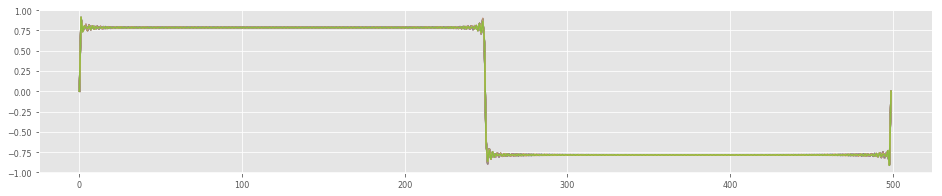

In [78]:
for i in range(20):
    plot(add_harmonics(i + 200, amp_harm_rel))

## Fourier series

Now that we refreshed the very basic trigonometric functions, we'll see how we can use a combination of $sin$ and $cos$ to approximate a periodic function.

If for a periodic function $f$ the following conditions hold
 1. $f$ is bounded with period $T$
 2. $f$ is integrable over the period
 
Then we can write $f$ as the *Fourier series*

$$f(t) = a_0 + \sum_{n=1}^\infty [a_n \cos(\omega_n t) + b_n \sin(\omega_n t)]$$

with $t\in [\frac{-T}{2},\frac{T}{2}]$, $n \in  \mathbb{N}$ and $\omega_n=\frac{2\pi}{T}n$ (this quantity is called *angular frequency*).

Since this is an infite sum, the more terms we add the better approximation of $f$ we will obtain.

The cofficients are given by the following formulae:

 * $\omega_n = \frac{2 \pi n}{T}$
 * $a_0 = \frac{2}{T} \int_{-\frac{T}{2}}^{\frac{T}{2}}{f(t) dt}$
 * $a_n = \frac{2}{T} \int_{\frac{-T}{2}}^\frac{T}{2}{f(t) \cos(\omega_n t) dt}$
 * $b_n = \frac{2}{T} \int_{\frac{-T}{2}}^\frac{T}{2}{f(t) \sin(\omega_n t) dt}$

The full derivation of the coefficient integrals goes beyond the scope of this lecture. The interested reader can consult eg.
http://ramanujan.math.trinity.edu/rdaileda/teach/s14/m3357/lectures/lecture_2_6_slides.pdf.

As an example we will approximate a [square wave](https://en.wikipedia.org/wiki/Square_wave) function using the Fourier series.

In [79]:
X = linspace(-20,20,10000)
y = []

def square_wave(x, T):
    return sign(sin(2*pi*x/T))
    
for x in X:
    y.append(square_wave(x, T=8))

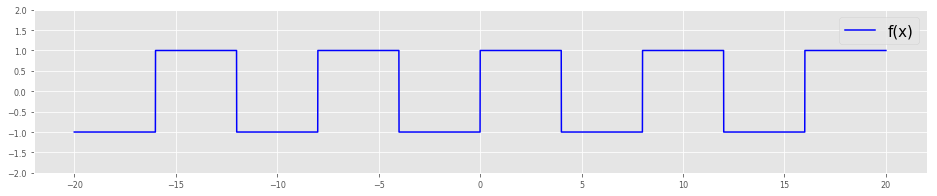

In [80]:
plot(X, y, color="blue", label="f(x)")
ylim(-2, 2)
legend(fontsize=15);

**Exercise:** What can we say about this function? 

**Answer:** It is non sinusoidal, integrable, periodic with period `T`, and the amplitude alternates at a steady frequency between a min and max value with the same duration at both the minimum and maximum. 

We'll now write some python functions to approximate the square wave.

In [81]:
def b_n(n):
    n = int(n)
    if (n%2 != 0):
        return 4/(np.pi*n)
    else:
        return 0

def w_n(n):
    T = 8
    wn = (2*pi*n)/T
    return wn

def fourier_series(max_n, x):
    a_0 = 0
    sums = a_0
    for n in range(1,max_n):
        sums += b_n(n) * np.sin(w_n(n)*x)
        
    return sums

Note that `b_n` is the analytic solution of the $b_n$ coefficient for the square wave function.

In [82]:
from IPython import display

In [83]:
num_harmonics = 20 # n term in the Fourier series
f = []
for i in X: 
    f.append(fourier_series(num_harmonics, i))

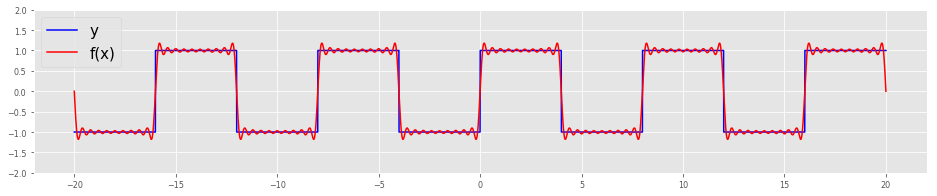

In [84]:
plot(X, y, color="blue", label="y")
plot(X, f, color="red", label="f(x)")
ylim(-2, 2)
legend(fontsize=15);

**Exercise**
Note that we took $a_i = 0,  \forall i \in [0,n]$. Why?

**Answer** we are approximating a square wave function of length $T$ over the range $[\frac{-T}{2},\frac{T}{2}]$ that can be written as 
$f(t) = 2 [H(\frac{t}{T}) - H(\frac{t}{T-1})]-1$, where 


$H(x) = \begin{cases} 0 &   \mbox{if} & x \lt 0 \\ \frac{1}{2} & \mbox{if} & x = 0 \\ 1 & \mbox{if} & x \gt 0 \\ \end{cases}$.



This function is also called the Heaviside step function.

$f(t) = f(2 T - 1)$, hence the function is odd, which implies $a_0$ = $a_n$ = 0.

**Bonus exercise**: Would all $a_i$ still be zero if we shifted the the square wave by a quarter period?

## The Fourier transform

### Complex exponents

**Exercise**: how can we represent the complex exponent in terms of $\sin$ and $\cos$ terms?
    
**Answer**: Euler's formula. $e^{i \varphi} = \cos \varphi + i \sin \varphi$

### Discrete Fourier Transform

Typically we will be working with discrete data, and use the discrete form of the Fourier transform (DTF). It is defined as

$$F_k = \frac{1}{N} \sum_{n=0}^{N-1}{f_n e^\frac{-2 i \pi n k}{N}}$$

where:
 * N is the number of samples in the time domain
 * $F_k$ is the DFT for frequency $k$
 * $k$ is the frequency 
 * $f_n$ is the value of the signal at time $n$

The discrete Fourier transform of a real sequence of numbers will be a sequence of complex numbers of the same length. You might be familiar with definitions of DFT that are not scaled. Here we are using the convention adopted by the `numpy` implementation.

The inverse DFT can be expressed in terms of the (forward) DFT, via several well-known tricks. An analytical discussion of these methods goes beyond the scope of this module.

To conceptualize DFT, think about an oscilloscope. An oscilloscope shows us voltage changing over time. It's DTF shows us what voltages are present at each frequency.

![dft](images/dft.png)

**Exercise:** let's reason about the plots axis and units of measure. 

**Answer:** the $y$ axis depicts the signal *amplitude* on both plots. If the input is measured in V, then the output is also V. Note however that the amplitude on the transform plot is unscaled.
The x axis of the signal plot (left) depicts time. The x axis on the transformed plots (rigth) depicts frequency and is dimensionless. Both plots on the right hand side of the arrow should make you raise an eyebrow. We'll get back to the real and imaginary components in a few moments. 

Let's first think of how we should interpret the real and imaginary components in the first place. Intuitively, the real portion of an DFT result is how much each frequency component resembles a cosine wave, the imaginary component how much each component resembles a sine wave (remember Euler's formula). If we look at them independently, they don't give much information. Instead, the magnitude of a frequency point $\sqrt{real^2 + imag^2}$ tells us something quite interesting: the amplitude at the corresponding frequency.
Discrete Fourier transforms (DFTs) are extremely useful because they reveal periodicities in input data as well as the relative strengths of any periodic components. 

### Fast Fourier Transform

**Exercise**: what is the time complexity of a naive computational implementation of DFT?

**Answer**: $\mathcal{O}(N^2)$ for $N$ points. For each of the $N$ points we have to multiply $K$ sinusoids and $K=N$

The Fast Fourier Transform (FFT) is a discrete Fourier transform algorithm which reduces the number of computations needed for $N$ points from $2N^{2}$ to $2N \log_{2}(N)$.

### Working with FFT in python

In this section we will get some familiarity with the `fft`  implementation in `numpy`. The reader interested in deeper implementation details should consult https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/

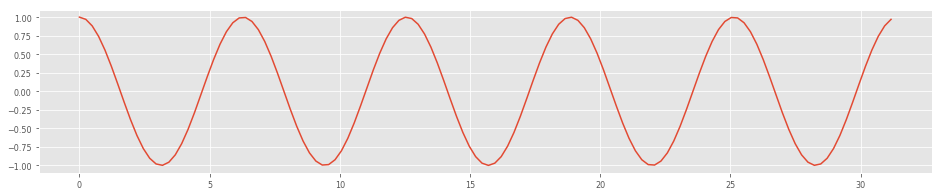

In [85]:
frequency = 5.0
phs = np.linspace(0, frequency * 2 * pi, 128, endpoint=False)
X = cos(phs)
plot(phs, X);

Another usueful function is `fftfreq` returns the frequency bin centers in cycles per unit of the sample spacing. For instance, if the sample spacing is in seconds, then the frequency unit is cycles/second. Think of the output of `fftfreq` as the $k$s in the DFT definition.

In [86]:
freqs = fftfreq(len(X), d=1/float(len(X)))

Numpy provides two methods that return the real and imaginary elements of an array: `real` and `imag`. Let's have a look at how we can use them to plot FFT features.

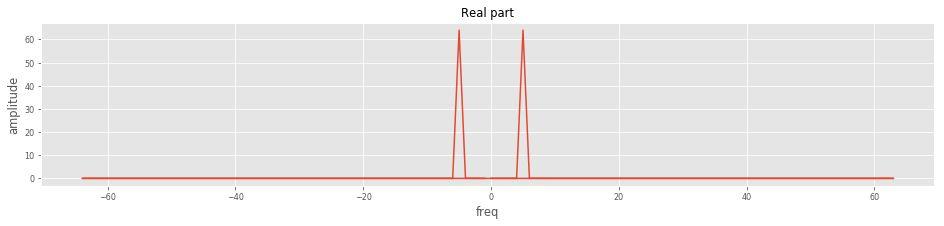

In [92]:
plot(freqs, real(fft.fft(X)));
title('Real part')
util.xlabel('freq')
util.ylabel('amplitude')

**Exercise**: do you notice anything strange here?

**Answer**: Two things stand out. There are negative frequencies, and there peaks at two frequencies. While our original signal had only one frequency! The short answer as to why this is the case, is that both are an artifact of working with Complex numbers.

By doing an FFT on a real signal of $N$ points we get a complex output of $N$ points with complex conjugate symmetry at $\frac{N}{2}$. This means that a periodic real function will contain two transformed peaks in two places, and we can think of the periods of the input data becoming split into "positive" and "negative" frequencies of the complex components. Numpy provides an `fft.rfft` and `fft.rfftfreq` methods that only return the "positive" frequencies  for real input. For a refresher on compelx conjugates see http://www.mathwords.com/c/complex_conjugate.htm

### Intermezzo: negative frequencies & Nyquist

Let's rewrite the formula for the DFT:

$$F_k = \frac{1}{N} \sum_{n=0}^{N-1}{f_n e^{-i\omega_0 n k}}$$

$$\omega_0 = 2\pi/N$$

Note that only frequencies are allowed that are a multiple of $\omega_0$, which is $2\pi/N$.
There is also a maximum angular frequency at $k=N/2$. This is called the Nyquist frequency and corresponds to a wavelength of 2 samples (phase shift of $\pi$ after each sample). Higher values of $k$ have higher phase shifts, but that can be translated into a negative phase shift in the opposite direction.

In the example below, we shall look at phase shifts between subsequent samples for different $\omega_k$. We have taken $N=16$ very low, so that we can easily visualize. Notice that the phase shift beyond the Nyquist can be seen as a phase shift from the opposite direction. It's basically the same effect as wheels from a car spinning in the opposite direction on video if the frame-rate is lower than the rate of revolution of the wheels.

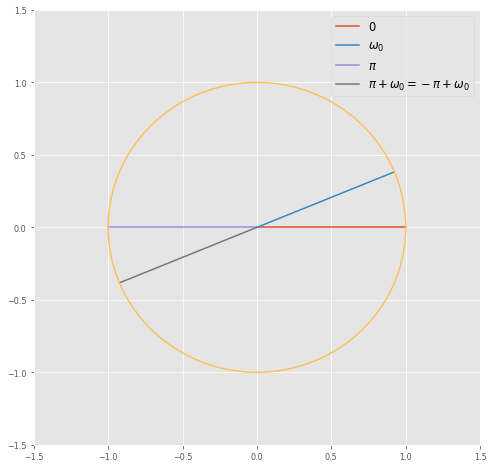

In [20]:
def plot_angle(angle):
    plot([0, cos(angle)], [0, sin(angle)])
   
util.figsize(8,8)
    
n = 16
omega_0 = 2*pi/n
plot_angle(0.)
plot_angle(omega_0)
plot_angle(omega_0*n/2)
plot_angle(omega_0*(n/2 + 1))

t = np.linspace(0, 2*pi, 250)
plot(cos(t), sin(t))
axes().set_xlim([-1.5, 1.5])
axes().set_ylim([-1.5, 1.5])

util.legend(['0', '$\omega_0$', '$\pi$', '$\pi + \omega_0 = -\pi + \omega_0$']);
util.figsize()

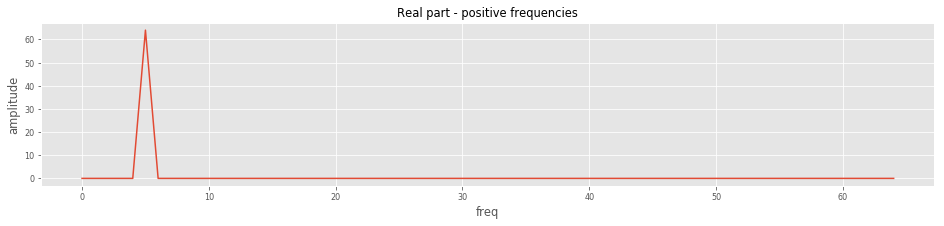

In [94]:
rfreqs = rfftfreq(len(X), d=1 / float(len(X)))
plot(rfreqs, real(fft.rfft(X)));
title('Real part - positive frequencies')
util.xlabel('freq')
util.ylabel('amplitude')

Similarly we can look at the imaginary part.

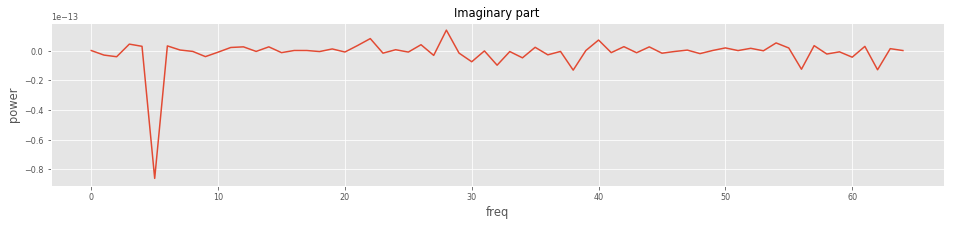

In [22]:
plot(rfreqs, imag(fft.rfft(X)))
title('Imaginary part')
util.xlabel('freq')
util.ylabel('power')

An important quantity in Fourier analysis is the **power spectrum**, that is a distribution of a signal's 'power' (e.g. decibel, pixel intensity, ...) over frequency. The **periodogram** computes the power spectra for the entire input signal: $|(F(x)|^2$.

In layman terms, power is defined as work of over time (https://en.wikipedia.org/wiki/Power_(physics)). Intuitively, the power spectrum tells us how much energy is concentrated at that frequency.

### Ok, that's all good, but this is how I would use the fft in a practical scenario:

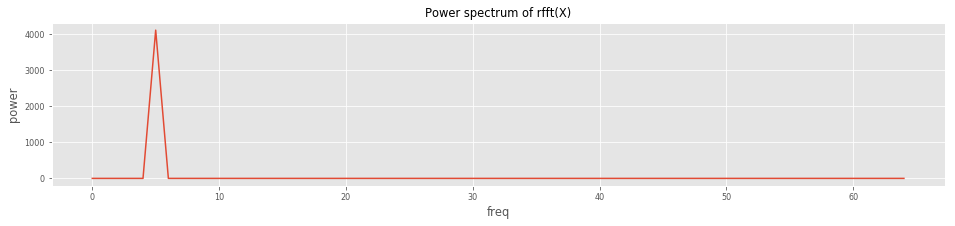

In [95]:
# rfft yields the positive components of the complex numbers only
# and as such are easier to interpret
power_spectrum = fft.rfft(X)**2
plot(power_spectrum)
title('Power spectrum of rfft(X)')
util.xlabel('freq')
util.ylabel('power')

# The general Fourier transform

***Any*** periodic function can be written as a Fourier series. i.e. any periodic function can be written as a sum of harmonic phasors.*

The continuos Fourier transform (FT) is defined as

$$S(f) = \int_{-\infty}^\infty{s(t) e^{- 2\pi i f t} dt}$$

Where $t$ represents time (eg. seconds) and $f$ represents frequency (eg. Hertz).

Notice the imaginary component $i$ in the exponent. Evaluating this quantity for all values of $f$ produces the *frequency-domain* function. Then $s(t)$ can be reconstructed as a function of complex exponential, by taking the inverse of $S(f)$:

$$ s(t) = \int_{-\infty}^\infty{S(f) e^{2\pi i f t} df} $$


The Fourier Transform is an important image processing tool which is used to decompose an image into its sine and cosine components. The output of the transformation represents the image in the Fourier or frequency domain, while the input image is the spatial domain equivalent.

![](images/Voice_waveform_and_spectrum.png)

In the more general sense we can use the Fourier transform to analyse any type of signal,
for which we are interested in observing its frequency components. In this module we (you) will apply FT to two common time serie analysis problems: extrapolation and outlier detection.

## Applications of the Fourier Transform

> “If your experiment needs statistics, you ought to have done a better experiment.”

>  Ernest Rutherford

In this section we will use FFT for some simple time series analysis. In the lecture we will show how FFT can be used to denoise a signal and detect periodicity. In the lab session you will be asked to implement aglorithms for outlier detection and forecasting.

## Noise filtering

In this section we will implement a bandpass filter to denoise a periodic signal.

We will use a *band-pass filter* function that rejects specific frequency ranges, then we will reconstruct the signal from the accepted frequencies using the inverse FFT.

We will illustrate denoising on an artifically generated sinuosoidal signal, to which we add some gaussian noise.

In [24]:
def ideal_signal(samples=None, timestep=None, amplitude=1, frequency=25):
    signal = [amplitude * np.cos((2 * np.pi) * frequency * sample * timestep) 
              for sample in range(samples)]
    return signal

In [25]:
def add_gaussian_noise(signal, mu=0, sigma=1):
    noise = [random.normal(mu, sigma) for _ in range(len(signal))]
    return [s + n for s, n in zip(signal, noise)]

In [26]:
samples = 1000
timestep = 0.001
signal = ideal_signal(samples=samples, timestep=timestep)
noisy_signal = add_gaussian_noise(signal)

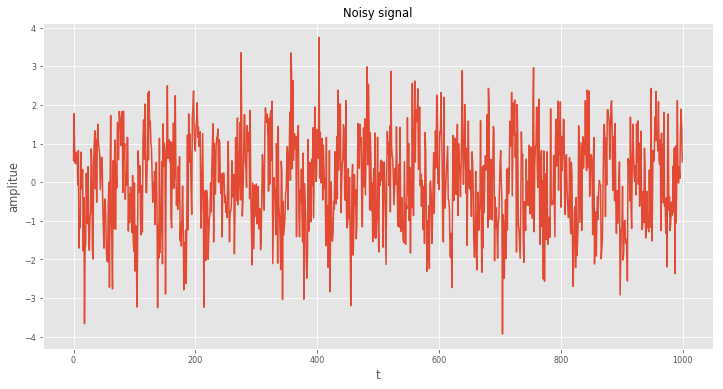

In [96]:
figure(figsize=(12, 6))
plot(noisy_signal)
title("Noisy signal");
util.xlabel('t')
util.ylabel('amplitue')

**Exercise:** can you guess what the original signal looks like?

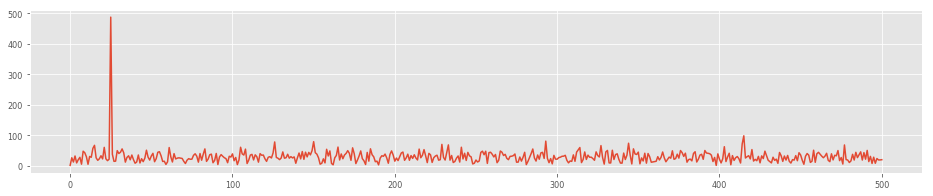

In [28]:
plot(abs(fft.rfft(noisy_signal)));

**Exercise**: you are encouraged to tweak the `timestep`, `amplitude`, `mu`, and `sigma` parameters. In particular, what happens if we increase the `mu` and `sigma` of the Gaussian noise? What is their impact on the FFT?

To implement a bandpass filter, we need to recover the true frequecies associated with the signal (eg. the $k$s in the DFT definition). **NOTE**: here we can't use `rfft` because both halves of the spectrum are needed to reconstruct the full signal on $N$ points with `ifft`.

In [99]:
n = len(noisy_signal)

In [100]:
fourier = fft.fft(noisy_signal)
f = fftfreq(n, d=timestep)

Remember that `fftfreq` returns the frequency bin centers in cycles per unit of the sample spacing. For instance, if the sample spacing is in seconds, then the frequency unit is cycles/second.

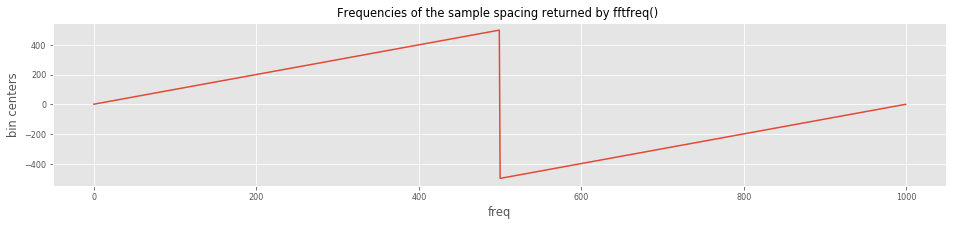

In [101]:
plot(f);
util.title('Frequencies of the sample spacing returned by fftfreq() ')
util.xlabel('freq')
util.ylabel('bin centers')

Again, notice that `fftfreq` reutrns frequency bins for both "positive" (first 500 points) and "negative" frequencies.

We implement a bandpass filter as follows

In [102]:
def bandpass_filter(x, freq, frequency=None, band=None):
    if (frequency - band) < abs(freq) < (frequency + band):
        return x
    return 0

In [103]:
assert len(f) == len(noisy_signal)

In [104]:
accepted_frequencies = [bandpass_filter(x, freq, frequency=25, band=1) 
 for x, freq in zip(fourier, f)]

**Exercise**: carefully review the `bandpass_filter` function. What is this code doing?

**Answer**: the function takes a point, its frequency bin center and only accepts frequencies within a given range. Notice that the number of frequency bins is equal to the number of samples. In our example we know that the frequency of the signal is `5`

In [105]:
filtered = fft.ifft(accepted_frequencies)

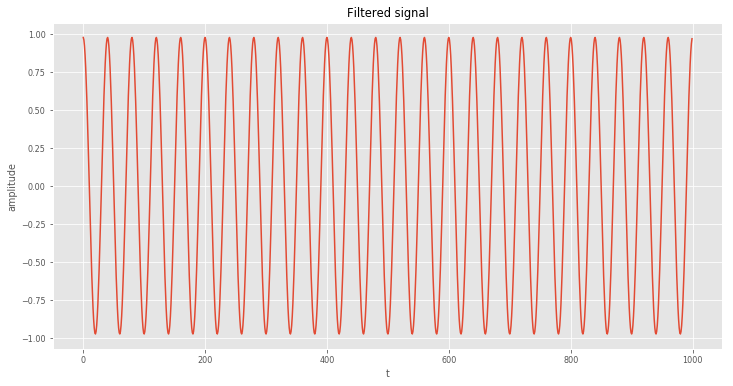

In [106]:
figure(figsize=(12, 6))
plot(np.arange(samples), real(filtered))
title("Filtered signal")
xlabel('t')
ylabel('amplitude');

## Periodicity

One method for detecting periodicity in a timeseries is to look at the power spectrum after we removed the signal trend and select the dominant frequencies. 

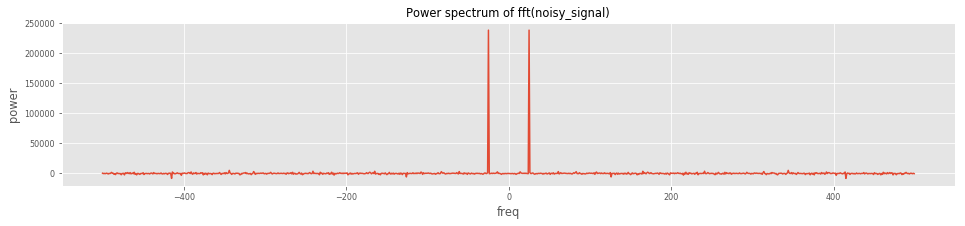

In [109]:
fourier = fft.fft(noisy_signal)
power_spectrum = fourier**2
idx = argsort(f)
plot(f[idx], power_spectrum[idx])
util.title('Power spectrum of fft(noisy_signal)')
util.xlabel('freq')
util.ylabel('power')

Again, we are plotting both the "negative" and "positive" frequencies for the signal.

**Exercise**: how can we plot only the "positive" frequencies?

**Answer**: An easy way to do so is using the `rfft` and `rfftfreq` functions

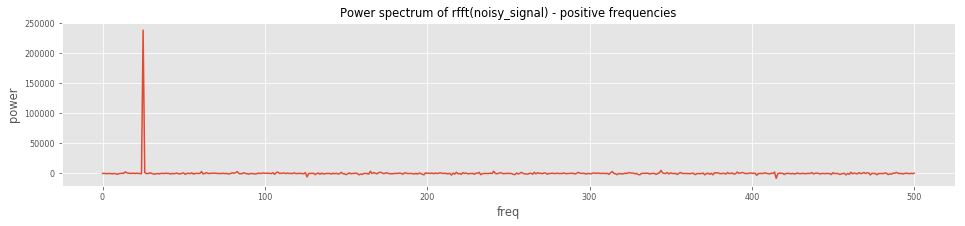

In [113]:
fourier = fft.rfft(noisy_signal)
rfreqs = fft.rfftfreq(n, d=timestep)
power_spectrum = fourier**2
plot(rfreqs, power_spectrum);

util.title('Power spectrum of rfft(noisy_signal) - positive frequencies')
util.xlabel('freq')
util.ylabel('power')

It is not immediately obvious from the plot, but by inspecting `power_spectrum` we can identify the dominant frequency of the signal

In [114]:
argmax(power_spectrum)

25

`25` is the dominant frequency, which is indeed the one we use to build the ideal signal.

### Extra: white noise

Let's have a look at the noise in the frequency domain in particular. The noise that we added is called 'white' noise.

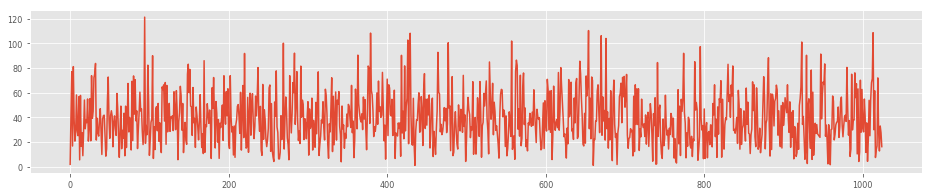

In [115]:
gaussian_noise = random.normal(size=2048, loc=0, scale=1)
plot(abs(fft.rfft(gaussian_noise)));

**Exercise**: Do you understand why it is called 'white' noise? Do you now also understand, why the amplitude of the filtered signal is not exactly one (the original signal has an amplitude of 1)? What would happen is de filter bandwidth is changed?

**Anwers**: 
* We see that the white noise does not contain preference for any particalar frequency band. It has a flat (albeit noisy) power spectrum. It's called white noise in analogy with white light. White light contains all light of all wave-lengths at equal power.
* The band-pass filter has removed the spectral content of the noise in allmost all frequencies, thereby greatly reducing the total power of the noise. However, the white noise has a contribution within the frequency band of our filter. This contribution is small compared to the original signal.
* More noise will seep through. This will not immediately look like noise though! See below.

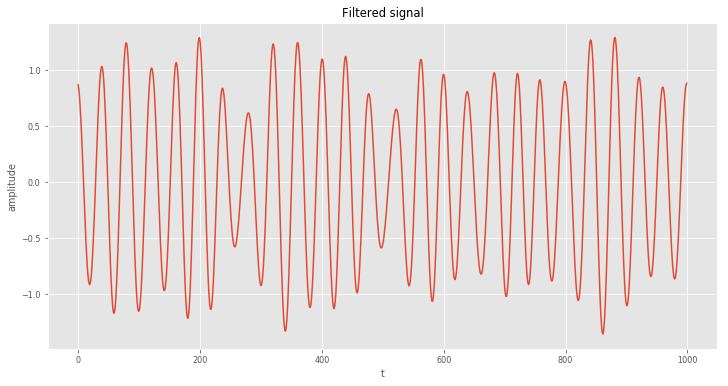

In [41]:
fourier = fft.fft(noisy_signal)
accepted_frequencies = [bandpass_filter(x, freq, frequency=25, band=10) 
                        for x, freq in zip(fourier, f)]
filtered = fft.ifft(accepted_frequencies)
figure(figsize=(12, 6))
plot(np.arange(samples), real(filtered))
title("Filtered signal")
xlabel('t')
ylabel('amplitude');

## Convolution Theorem

Recall the definition of convolution:
$$(f*g)[\tau]=\sum_{t=-T}^T f[\tau-t]g[t].$$

**Exercise**: What is the computational complexity to calculate $(f*g)[\tau]$ at $\tau=[1,...,N]$?

**Answer**: The complexity for calculating a single value for $\tau$ is $2(T+1)$. The total complexity therefore is $2N(T+1)$. That is $\mathcal{O}(N^2)$ (i.e. double for-loop) if the convolution window has size $N$.

**Theorem**: *Convolution in the time domain is equivalent to multiplication in the frequency domain and vice versa.*

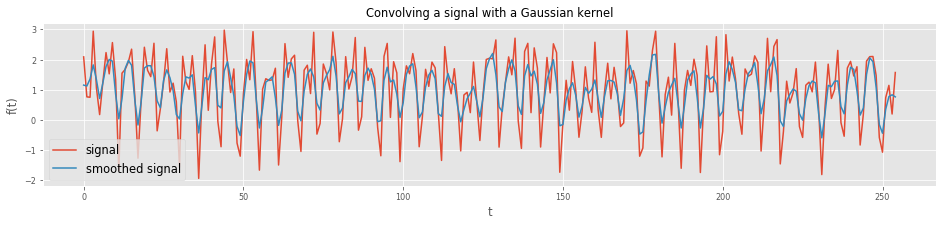

In [42]:
from scipy.signal import gaussian

def f(t):
    return sin(t) + cos(t*2) + 2*random.rand(len(t))

g = gaussian(3, 1)
t = arange(255)
v = f(t)

def plot_gaussian_convolution_example(g,t,v):
    plot(t, v)
    plot(t, convolve(v, g/sum(g), 'same'))
    util.legend(['signal', 'smoothed signal'])
    util.title('Convolving a signal with a Gaussian kernel')
    util.xlabel('t')
    util.ylabel('f(t)')
    
plot_gaussian_convolution_example(g,t,v)

Let's see what is the effect of convolution on the spectrum. Note that for clarity we'll return only the positive frequencies of the spectrum (eg. on $\frac{N}{2}$ points).

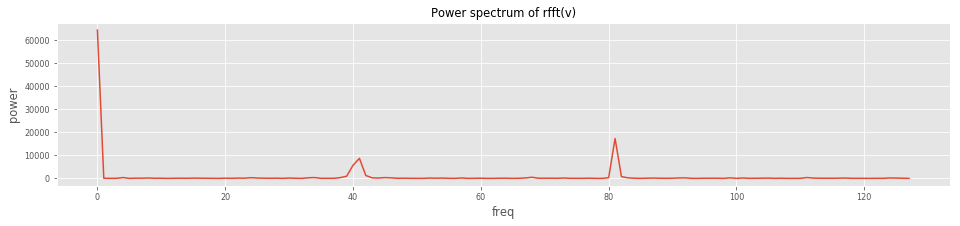

In [43]:
freq = rfftfreq(len(t), d=1/float(len(t)))

power_spectrum = absolute(fft.rfft(v))**2
idx = argsort(freq)

plot(freq[idx], power_spectrum[idx]);
util.title('Power spectrum of rfft(v)')
util.xlabel('freq')
util.ylabel('power')

And then on the convolved signal. Recall that `np.convolve` takes three parameters: a signal (`v`), a window `g/sum(g)` and a flag, `'same'` that indicates that the result should have the same length as the input.

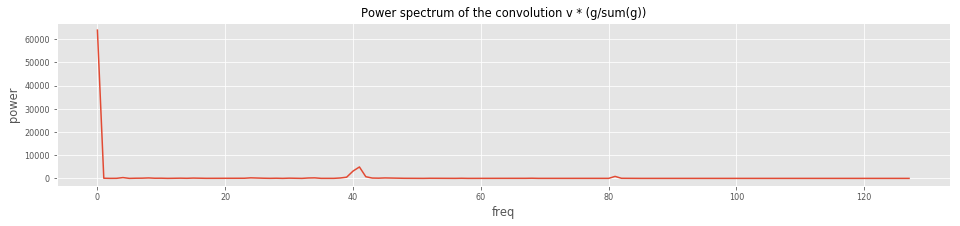

In [44]:
window =  g/sum(g)
convolved = convolve(v, window, 'same')

power_spectrum_convolved = absolute(fft.rfft(convolved))**2
idx = argsort(freq)

plot(freq[idx], power_spectrum_convolved[idx]);
util.title('Power spectrum of the convolution v * (g/sum(g))')
util.xlabel('freq')
util.ylabel('power')

Can you describe the difference between these two plots? 
The fundamental frequency is almost unchanged, and the first two harmonics are attenuated (lower amplitude). The higher harmonics are (almost) eliminated. 

**Exercise**: does this look familiar?
    
**Answer**: convolution has the effect of a low-pass filter

### Back to the Convolution Theorem

The Convolution Theorem says that given two functions $f$ and $g$:

$$ \mathrm{FT}(f * g) = \mathrm{FT}(f) \cdot \mathrm{FT}(g). $$

When we convolve the signal we are working in the time domain, while when we multiply DFTs we are working in the frequency domain. As shown in the `ratio` plot above, when we convolve a wave (the signal `v`) and a window (the convolution `window = g/sum(g)`), we multiply the spectrum of the wave with the spectrum of the window.
Let's now making this more explicit.

In [45]:
N = (len(t)-len(window)) / 2
padded = pad(window, int(N), 'constant', constant_values=0)
dft_window = fft.rfft(padded)

We zero-pad the window so to match the signal length,  then we calculate the power spectrum of DFT(g)

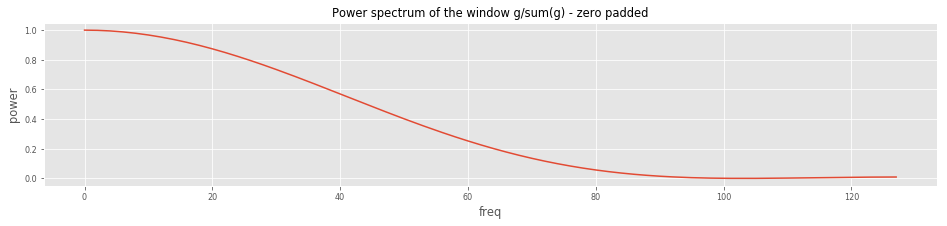

In [46]:
power_spectrum_window = absolute(dft_window)**2
idx = argsort(freq)
plot(freq[idx], power_spectrum_window[idx]);

util.title('Power spectrum of the window g/sum(g) - zero padded')
util.xlabel('freq')
util.ylabel('power')

Let's now take the product of the window and signal power spectra.

We notice a dominant frequency 15, but with very low power. We can interpret this as a lack of periodicity in `window`.

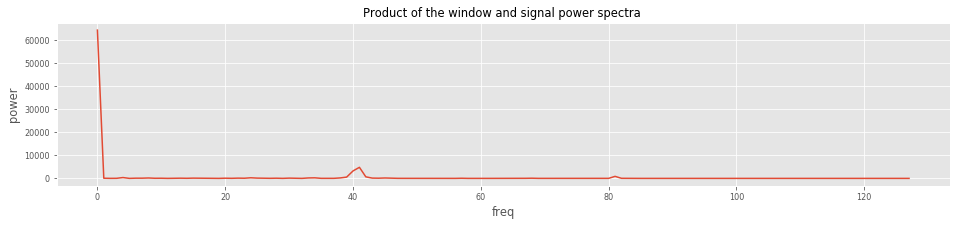

In [47]:
prod = power_spectrum_window * power_spectrum
plot(freq[idx], prod[idx]);

util.title('Product of the window and signal power spectra ')
util.xlabel('freq')
util.ylabel('power')

## This equals the power spectrum of the convolved signal  !!!!

### Computational complexity

**Exercise**: Can we use the convolution theorem to speed-up calculations? What would then be the computational complexity of doing it this way?

**Answer**: We need to compute the Fourier transforms twice. Once for $f$ and once for $g$. The FFT has complexity $N\log_2(N)$. Furthermore, we need to multiply in the frequency domain. This has complexity $N$. Then transform back to the time domain:  $N\log_2(N)$. Total complexity therefore is:

$$3N\log_2(N) + N \Rightarrow \mathcal{O}(N\log(N)).$$

Note that the naive way of doing gives $\mathcal{O}(N^2)$.

For small window sizes $(N<10)$, the overhead of doing Fourier transforms makes things a bit slower

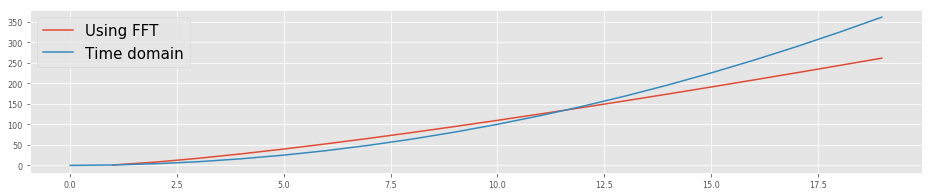

In [48]:
N = arange(0, 20)
plot(N, 3*N*log2(N) + N, label="Using FFT")
plot(N, N*N, label="Time domain")
legend(fontsize=15);

However, as the number of point increase, Fourier will be much better:

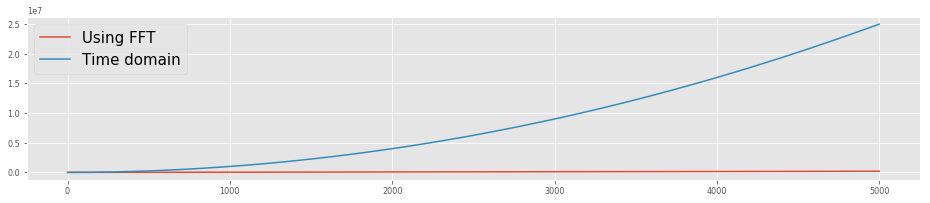

In [49]:
N = arange(0, 5000)
plot(N, 3*N*log2(N) + N, label="Using FFT")
plot(N, N*N, label="Time domain")
legend(fontsize=15);

# Backup: Demystifying the integrals in the Fourier transform

We are going to mimic what is going on under the hood of these nasty integrals.

In the code below we have multiplied a cosine signal by another cosine with different frequency and calculate the sum. Note that this corresponds to one of $a_n$ terms. Have a look at the function and understand the graphs.

Note that if we mulitply by a cosine with a frequency that is different from the frequency in the signal, the integral (sum) is zero. This is true for all frequencies except for the case when k_signal is equal to k_test. Note also the differences in the graphs: 
* when k_test != k_signal: positive and negative values cancel ==> integral is zero
* when k_test == k_signal: we are basically calculating $\cos^2(x)$ which is always larger than zero for all values.

Try out some different integer values for k and notice that it always works. 

**Exercise**: What happens if $k$ is non-integer? 

**Answer**: Then function $f$ is not periodic and we do not satisfy the preconditions for Fourier.

For those interested and having backing in linear algebra: this is actually an orthogonality relation. See for more details: https://www.macalester.edu/aratra/edition2/chapter1/chapt1d.pdf

In [50]:
def cosine_product(k_signal, k_test):
    x = linspace(0, 2*pi, 250, endpoint=False)
    y1 = cos(k_signal*x)
    y2 = cos(k_signal*x) * cos(k_test*x)
    plot(x, y1, label='signal')
    plot(x, y2, label='product')
    plt.legend()
    plt.axhline(y=0, color='k')


    print("Integral = {:2.1f}".format(sum(y2)))

Integral = 0.0


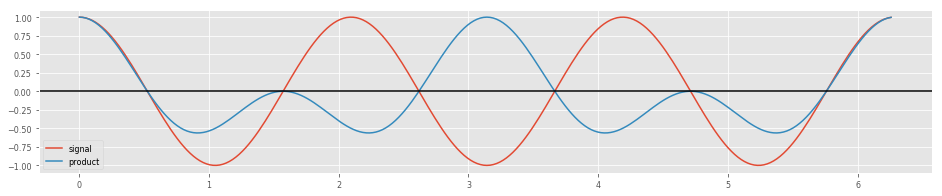

In [51]:
cosine_product(3,1)

Integral = 0.0


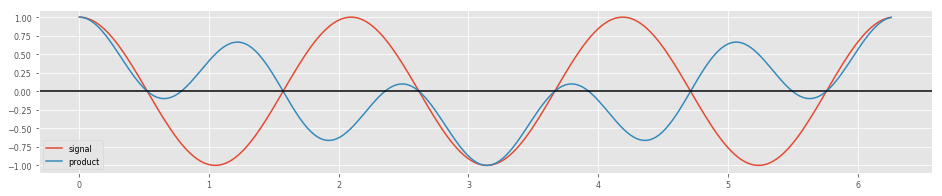

In [52]:
cosine_product(3,2)

Integral = 125.0


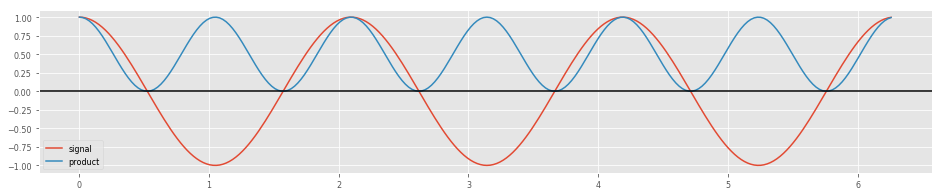

In [53]:
cosine_product(3,3)

Integral = 0.0


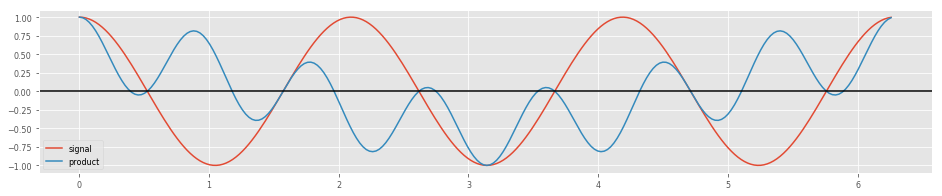

In [54]:
cosine_product(3,4)